In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Sources
- https://huggingface.co/google/mt5-base
- https://medium.com/@tskumar1320/how-to-fine-tune-pre-trained-language-translation-model-3e8a6aace9f
- https://www.geeksforgeeks.org/machine-translation-with-transformer-in-python/
- https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb
- https://thepythoncode.com/article/machine-translation-using-huggingface-transformers-in-python
- https://blog.speechmatics.com/huggingface-translation-triton
- https://github.com/christianversloot/machine-learning-articles/blob/main/easy-machine-translation-with-machine-learning-and-huggingface-transformers.md

# Install Libraries and Modules

In [2]:
import warnings
warnings.filterwarnings('ignore') 

## WANDB Config

In [3]:
!pip -q uninstall -y wandb
!pip -q install wandb==0.17.5 
import wandb
!wandb offline
!wandb disabled
os.environ["WANDB_DISABLED"] = "true"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 3.6 MB/s eta 0:00:0000:0100:01m
W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.
W&B disabled.


In [4]:
!pip -q install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.7 MB/s eta 0:00:00


In [5]:
!pip install -q datasets evaluate sentencepiece accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.8 MB/s eta 0:00:00


In [6]:
!pip uninstall transformers -y
!pip -q install transformers==4.45.2

Found existing installation: transformers 4.47.0
Uninstalling transformers-4.47.0:
  Successfully uninstalled transformers-4.47.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 37.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 83.0 MB/s eta 0:00:00:00:01


In [7]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import MT5ForConditionalGeneration, MT5Tokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import EvalPrediction
import evaluate

In [8]:
class TranslationDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length=128):
        """
        Initializes the TranslationDataset.

        Args:
            file_path (str): Path to the JSONL file containing the pre-flattened data.
            tokenizer (transformers.PreTrainedTokenizer): The tokenizer to use for encoding.
            max_length (int): The maximum length for tokenized sequences.
        """
        with open(file_path, 'r', encoding='utf-8') as f:
            self.data = [json.loads(line) for line in f]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves the tokenized inputs and labels for a given index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: A dictionary containing input IDs, attention mask, and labels.
        """
        item = self.data[idx]
        source = item['source']
        target = item['target']

        # Tokenize the source text
        inputs = self.tokenizer(
            source,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        # Tokenize the target text and prepare labels
        labels = self.tokenizer(
            target,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )['input_ids']
        # Replace padding token IDs with -100 for loss computation
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': labels.squeeze()
        }

In [9]:
from peft import get_peft_model, LoraConfig, TaskType


lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  
    r=16, 
    lora_alpha=64,  
    lora_dropout=0.1,  
    bias="none",
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
        "fc1",
        "fc2"
    ]
)

In [10]:
# Step 3: Load Pre-trained Model and Tokenizer
model_name = "Helsinki-NLP/opus-mt-en-jap"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/509k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/274M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [11]:
print(model)

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(80035, 512, padding_idx=80034)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(80035, 512, padding_idx=80034)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [11]:
model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

trainable params: 2,616,384 || all params: 70,972,480 || trainable%: 3.6865
None


In [12]:
# Step 4: Prepare Data
train_dataset = TranslationDataset('/kaggle/input/semeval.train./semeval/train/ja/train.jsonl',
                                   tokenizer)
dev_dataset = TranslationDataset('/kaggle/input/flattened_validation_dataset_ja.jsonl',
                                 tokenizer)

In [13]:
len(train_dataset)

7225

In [14]:
len(dev_dataset)

1409

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=8)

In [16]:
from transformers import EarlyStoppingCallback

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  
    early_stopping_threshold=0.0001  
)

In [35]:
!rm -rf /kaggle/working/*

# facebook/m2m100_418M

In [17]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results/it/opus-mt-en-jap-v1",
    report_to=None,
    evaluation_strategy="steps",
    logging_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=1,
    predict_with_generate=True,
    load_best_model_at_end = True,
    metric_for_best_model="bleu",
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [18]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]  # Ensure labels are lists of lists
    return preds, labels

In [19]:
bleu = evaluate.load("sacrebleu")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)

    result = {k: round(v, 4) for k, v in result.items()}

    return result


In [20]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

In [21]:
from unittest import mock
from unittest.mock import Mock
class Dummy:
    def __enter__(self):
        return Mock()

    def __exit__(self, *args):
        pass

In [22]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Bleu,Gen Len
500,2.372200,0.720850,0.000000,4.000000
1000,0.951000,0.604635,0.000000,4.011400
1500,0.863000,0.575122,0.000000,4.043300
2000,0.816400,0.575553,0.000000,4.073100


In [23]:
model.save_pretrained("./trained_model")
tokenizer.save_pretrained("./trained_model")

('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/vocab.json',
 './trained_model/source.spm',
 './trained_model/target.spm',
 './trained_model/added_tokens.json')

In [24]:
eval_results = trainer.evaluate()
print(f"The Results on Evaluation dataset during fitting are: {eval_results}")
print(f"Validation BLEU Score: {eval_results['eval_bleu']}") 

# Extract BLEU scores from log history
bleu_scores = [log['eval_bleu'] for log in trainer.state.log_history if 'eval_bleu' in log]

The Results on Evaluation dataset during fitting are: {'eval_loss': 0.7208500504493713, 'eval_bleu': 0.0, 'eval_gen_len': 4.0, 'eval_runtime': 39.9509, 'eval_samples_per_second': 35.268, 'eval_steps_per_second': 2.228, 'epoch': 4.424778761061947}
Validation BLEU Score: 0.0


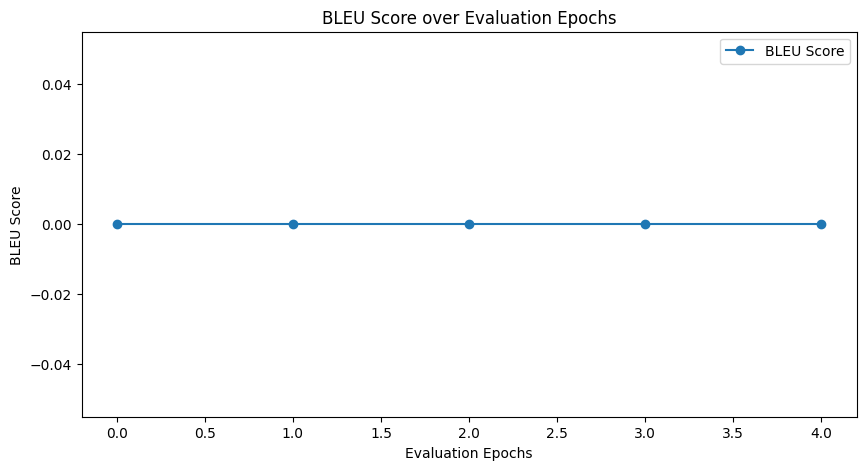

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(bleu_scores, marker='o', label="BLEU Score")
plt.xlabel("Evaluation Epochs")
plt.ylabel("BLEU Score")
plt.title("BLEU Score over Evaluation Epochs")
plt.legend()
plt.show()

In [26]:
class TestDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length=128):
        with open(file_path, 'r', encoding='utf-8') as f:
            self.data = [json.loads(line) for line in f]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        source = item['source']
        inputs = self.tokenizer(
            source, max_length=self.max_length, truncation=True, padding='max_length', return_tensors='pt'
        )
        return {
            'id': item['id'],
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze()
        }

In [27]:
# Load Test Data
test_dataset = TestDataset('/kaggle/input/semeval.test_hidden/test_without_targets/ja_JP.jsonl', tokenizer)

In [28]:
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): MarianMTModel(
      (model): MarianModel(
        (shared): Embedding(46276, 512, padding_idx=46275)
        (encoder): MarianEncoder(
          (embed_tokens): Embedding(46276, 512, padding_idx=46275)
          (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
          (layers): ModuleList(
            (0-5): 6 x MarianEncoderLayer(
              (self_attn): MarianAttention(
                (k_proj): lora.Linear(
                  (base_layer): Linear(in_features=512, out_features=512, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=512, out_features=16, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=16, out_features=512, bias=False)
        

In [47]:
device

device(type='cuda')

In [30]:
model.eval()

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): MarianMTModel(
      (model): MarianModel(
        (shared): Embedding(46276, 512, padding_idx=46275)
        (encoder): MarianEncoder(
          (embed_tokens): Embedding(46276, 512, padding_idx=46275)
          (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
          (layers): ModuleList(
            (0-5): 6 x MarianEncoderLayer(
              (self_attn): MarianAttention(
                (k_proj): lora.Linear(
                  (base_layer): Linear(in_features=512, out_features=512, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=512, out_features=16, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=16, out_features=512, bias=False)
        

In [31]:
test_jsonl_path = "/kaggle/input/semeval.test_hidden/test_without_targets/ja_JP.jsonl"
source_texts = {}

with open(test_jsonl_path, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        source_texts[data["id"]] = data["source"]

In [32]:
predictions = []

for batch in tqdm(test_dataloader, desc="Generating Predictions", colour="blue"):
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=batch["input_ids"].to(model.device),
            attention_mask=batch["attention_mask"].to(model.device),
            max_length=128
        )
        prediction = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

        batch_id = batch["id"][0]  
        source_text = source_texts[batch_id]

        # print(f"The source text is: {source_text}")
        # print(f"The prediction text is: {prediction}")
        
        predictions.append({
            "id": batch_id,
            "source_language": "English",
            "target_language": "Italian",
            "text": source_text,
            "prediction": prediction
        })
        # print(predictions)

Generating Predictions: 100%|██████████| 5108/5108 [07:35<00:00, 11.22it/s]


In [36]:
predictions[:5]

[{'id': 'e033d5afc49c9c27',
  'source_language': 'English',
  'target_language': 'Italian',
  'text': 'What is the significance of Šarena Mosque in Tetovo, North Macedonia?',
  'prediction': 'Qual è il masa di Šarena a Tetovo, Macedonia del Nord?'},
 {'id': '57b14b52b7758492',
  'source_language': 'English',
  'target_language': 'Italian',
  'text': 'How would you describe the architectural style of Šarena Mosque?',
  'prediction': 'Qual è la descrivizione dello stolo atblicico della mosque di Šarena?'},
 {'id': 'dfdbdd81c476c5e2',
  'source_language': 'English',
  'target_language': 'Italian',
  'text': 'In which city is Šarena Mosque located?',
  'prediction': 'In quale città si trova la moschea di Šarena?'},
 {'id': '00bcab05e9ecd57b',
  'source_language': 'English',
  'target_language': 'Italian',
  'text': 'Where is the Basilica of St. Sernin situated?',
  'prediction': 'Dove si trova la Basilica di S. Serin?'},
 {'id': '99fd605868d203e8',
  'source_language': 'English',
  'target

In [33]:
len(predictions)

5108

In [34]:
# Save Predictions
with open('ar_AE_opus-mt-en-ja-v1.jsonl', 'w') as f:
    for pred in predictions:
        f.write(json.dumps(pred, ensure_ascii=False) + '\n')